# Introducción del Caso de Uso

En este caso, me enfrento con la ayuda de dos compañeros a una competición en el que vamos a tener que implementar un **modelo de predicción para calcular el tiempo que un paciente va a estar en la UCI**, y por tanto, conocer la presión en las UCIs de cada centro hospitalario y poder derivar a los pacientes graves a los centros con menor presión. 

La única condición que nos ponen desde Dedalus (empresa organizadora) es que no hay restricciones, solamente una fecha límite de entrega y defensa de la solución implementada. En este caso nosotros eramos 3 participantes y pudimos reunirnos 3 días de la semana que nos dejaron. 

Para introducir la importancia del caso nos hemos tomado la molestia de buscar estadísticas de los hospitales españoles, que se resumen en la siguiente imagen:

<img src="./img/Diapositiva1.PNG">

El proceso que seguimos lo dividimos en 7 pasos diferentes, desde definir el objetivo de nuestro trabajo hasta la presentación de nuestra solución final. Los primeros **6 pasos fueron parte de lo que se conoce como entendimiento, análisis y preprocesado de los datos**, y se pueden ver de manera gráfica en la siguiente diapositiva: 

<img src="./img/Proceso.PNG">

Empecemos por el objetivo del trabajo: 

<img src="./img/Objetivos.PNG">

- **Análisis del conjunto de datos**: Es un modelo relacional como 31 tablas y donde cada tabla posee varios atributos, por tanto, no es un modelo trivial que se puede entender de un vistazo al modelo relacional.


- **Entender el caso de uso**: Dado que prácticamente ninguno de los integrantes tenemos conocimientos medicos, debemos dedicarle tiempo a buscar información en artículos y papers, con el objetivo de hacernos una idea de este caso


- **Valorar diferentes aproximaciones**: Dependiendo de los datos el problema se puede afrontar de diferentes maneras, como por ejemplo, diferenciando si se va a utilizar un modelo de regresión o de clasificación. Posteriormente, entraré más en profundidad de la solución final planteada


- **Solución realista y práctica**: No deja de ser un caso de uso real y tenemos que tener en mente durante todo el proceso que debemos implementar una arquitectura y un modelo aplicable a la realidad

Por último, antes de comenzar con el código puro, he de decir que parte del análisis exploratorio realizado sobre el conjunto de datos no está dentro de este notebook, ya que he decidido centrarme en un flujo E2E con datos fijos. Es decir, voy a partir de unos datasets(tablas) y  voy a exponer el análisis para estos datos, saltandome la parte de selección de tablas, porque creo que mete más ruido que valor. 

**!!EMPECEMOS¡¡**

# Librerías y Ruta

La primera sección del notebook la he querido dedicar para exponer el conjunto de librerías usadas, de tal manera que las dependencias del proyecto no estén definidas por todo el notebook, y se concentren en una celda

In [1]:
# Esta celda estba dedicada a montar el repositorio de datos en Google Colab que es donde trabajamos

#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


import scipy.stats

from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier

from category_encoders import CountEncoder

from xgboost import XGBRegressor
from xgboost import XGBClassifier

In [3]:
# Variable para establecer donde están los datasets
ruta_datasets = './datasets/'

# Dataset Paciente

Empecemos exponiendo el análisis realizado sobre el dataset central, el conjunto de datos que contiene la información primaria de cada admisión de pacientes en una UCI. La idea que hemos planteado es tratar los datos de este dataset y posteriormente, añadir columnas(características) procedentes de los otros datasets elegidos.

## Carga del Dataset

In [4]:
data = pd.read_csv(ruta_datasets+"patient.csv")

In [5]:
data.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,141764,129391,Female,87,Caucasian,59,91,NaN,157.5,23:36:00,...,ICU to SDU,2,stepdown/other,NaN,NaN,18:58:00,344,Home,Alive,002-1039
1,141765,129391,Female,87,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",157.5,23:36:00,...,Emergency Department,1,admit,46.5,45.0,13:14:00,2250,Step-Down Unit (SDU),Alive,002-1039
2,143870,131022,Male,76,Caucasian,68,103,"Endarterectomy, carotid",167.0,20:46:00,...,Operating Room,1,admit,77.5,79.4,10:00:00,793,Floor,Alive,002-12289
3,144815,131736,Female,34,Caucasian,56,82,"Overdose, other toxin, poison or drug",172.7,01:44:00,...,Emergency Department,1,admit,60.3,60.7,20:48:00,1121,Other External,Alive,002-1116
4,145427,132209,Male,61,Caucasian,68,103,"GI perforation/rupture, surgery for",177.8,23:48:00,...,Operating Room,1,admit,91.7,93.1,22:47:00,1369,Floor,Alive,002-12243


## Análisis Previo

Este análisis se va a dividir en vairos pasos, lo primero seleccionar las columnas que nos aportan valor según hemos podido investigar en el enlace al modelo de datos: https://eicu-crd.mit.edu/about/eicu/

In [6]:
data = data[['patientunitstayid', 'gender', 'age', 'hospitalid', 'apacheadmissiondx','admissionheight', 'unittype',
             'unitadmitsource', 'unitvisitnumber', 'unitstaytype', 'unitdischargeoffset']]

In [7]:
data.shape

(2520, 11)

Es esencial conocer los tipos de cada característica que python ha detactado en la carga de variables. Así sabremos si por ejemplo, una columna dedicada a la edad lo detecto como texto, número entero o decimal.

In [8]:
data.dtypes

patientunitstayid        int64
gender                  object
age                     object
hospitalid               int64
apacheadmissiondx       object
admissionheight        float64
unittype                object
unitadmitsource         object
unitvisitnumber          int64
unitstaytype            object
unitdischargeoffset      int64
dtype: object

El siguiente piso es hacernos una idea de los valores que tiene cada característica númerica. De tal manera que podemos detectar outliers, datos potencialmente erróneos, distribuciones, etcétera de un solo vistazo.

In [9]:
data.describe()

,patientunitstayid,hospitalid,admissionheight,unitvisitnumber,unitdischargeoffset
count,2.520000e+03,2520.000000,2451.000000,2520.000000,2520.000000
mean,1.666226e+06,261.042460,169.740445,1.200000,3484.075000
std,1.022224e+06,119.109829,15.986092,0.510003,4977.160994
min,1.417640e+05,56.000000,0.300000,1.000000,0.000000
25%,7.722628e+05,158.000000,162.600000,1.000000,1137.750000
50%,1.590372e+06,252.500000,170.200000,1.000000,2120.000000
75%,2.697422e+06,384.500000,177.800000,1.000000,3998.500000
max,3.353113e+06,459.000000,600.000000,5.000000,66499.000000


Posteriormente, hacemos un análisis parecido pero aplicado a las características categóricas. Por ejemplo, nos permiter detectar el porque ha detectado la característica edad como un objeto y no con un número, a partir de 90 años lo clasifican como '>89'

In [10]:
data.describe(exclude=[np.number])

,gender,age,apacheadmissiondx,unittype,unitadmitsource,unitstaytype
count,2516,2516,2221,2520,2498,2520
unique,2,76,236,8,13,4
top,Male,> 89,"Sepsis, pulmonary",Med-Surg ICU,Emergency Department,admit
freq,1508,98,121,1898,1304,2064


Como en todo proyecto de Big Data y análisis de datos debemos conocer cuantos valores nulos("missing data") tiene cada característica. Con la siguiente instrucción obtenemos una lista que nos expone en porcentaje absoluto cuantos valores nulos tiene cada característica. Cabe destacar, que según la documentación(link anterior) de este modelo de datos, ninguna de las características seleccionadas para Patient define un valor específico a los valores nulos, dicho con otras palabras, los valores nulos no tienen un significado propio. 

In [11]:
data.isnull().sum() / data.shape[0]

patientunitstayid      0.000000
gender                 0.001587
age                    0.001587
hospitalid             0.000000
apacheadmissiondx      0.118651
admissionheight        0.027381
unittype               0.000000
unitadmitsource        0.008730
unitvisitnumber        0.000000
unitstaytype           0.000000
unitdischargeoffset    0.000000
dtype: float64

Como último paso de este análisis previo de Patient, he decidido mostrar una lista de las frecuencias absolutas de cada valor categórico en cada uno de sus niveles.

In [12]:
for col in data.columns[data.dtypes==object]:
    display((data.groupby([col]).size()/data.shape[0]).reset_index(name='counts'))

,gender,counts
0,Female,0.400000
1,Male,0.598413


,age,counts
0,15,0.000397
1,16,0.000397
2,17,0.000794
3,18,0.003175
4,19,0.003175
...,...,...
71,86,0.010317
72,87,0.017063
73,88,0.009921
74,89,0.011508


,apacheadmissiondx,counts
0,"ARDS-adult respiratory distress syndrome, non-...",0.003571
1,Abdomen only trauma,0.000397
2,Abdomen/extremity trauma,0.000794
3,Abdomen/multiple trauma,0.000397
4,Ablation or mapping of cardiac conduction pathway,0.000794
...,...,...
231,"Vascular medical, other",0.002778
232,"Vascular surgery, other",0.000794
233,Vena cava filter insertion,0.000397
234,Ventriculostomy,0.000397


,unittype,counts
0,CCU-CTICU,0.032540
1,CSICU,0.025794
2,CTICU,0.020635
3,Cardiac ICU,0.052778
4,MICU,0.056349
5,Med-Surg ICU,0.753175
6,Neuro ICU,0.025794
7,SICU,0.032937


,unitadmitsource,counts
0,Acute Care/Floor,0.022222
1,Chest Pain Center,0.000794
2,Direct Admit,0.055952
3,Emergency Department,0.517460
4,Floor,0.130952
5,ICU,0.020635
6,ICU to SDU,0.058730
7,Operating Room,0.100397
8,Other Hospital,0.009921
9,Other ICU,0.012302


,unitstaytype,counts
0,admit,0.819048
1,readmit,0.038492
2,stepdown/other,0.110714
3,transfer,0.031746


## Tratamiento Features

Pasamos a hacer las primeras transformaciones sobre el conjunto de datos. Cambiar la columna age a entero y rellenar sus missing data por un número provisional para posteriormente tratar esta columna con el resto de columnas númericas con mssing data. Se ha decidido sustituir todos los valores ">89" por edad = 90.

In [13]:
data.loc[data['age'] == '> 89', ['age']] = 90
data['age'] = data['age'].fillna(-1).astype(int)

In [14]:
data['gender'].unique()

array(['Female', 'Male', nan], dtype=object)

## Análisis estadístico y visual
Para entender el problema que se plantea en este caso de uso debemos conocer en profundidad la variable objetivo (target). Para ello vamos a tratarla, entenderla y hacer un primer estudio de como interactuan las demás variables del dataset Patient con dicho target.

En este caso, el target es la variable 'unitdischargeoffset' y viene dada en minutos de estancia de un paciente en la UCI. El primer cambio para entender mejor esta variable va a ser transformarla a número de días. Es decir, dividir los minutos entre 1440, para obtener el número de días.

In [15]:
data['target_dias'] = data['unitdischargeoffset']/1440

In [16]:
plt.clf()
plt.cla()
plt.close()

Lo primero que creemos esencial, es conocer la distribución de la variable objetivo, para conocer varios aspectos: como de concentrado esta la masa en un tramo, si sigue una distribución normal, si existen posibles outliers o valores extremos.

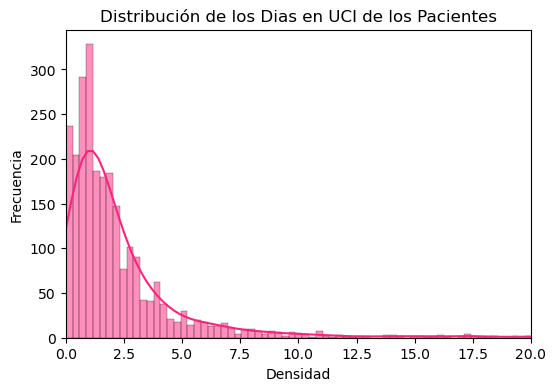

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=data, x='target_dias', kde=True, color=(1, 0.137, 0.49), ax=ax)
ax.set(title='Distribución de los Dias en UCI de los Pacientes', xlabel='Densidad', ylabel='Frecuencia', xlim=(0, 20))

# Mostrar el displot
plt.show()

En este caso, vemos que la gran parte de los pacientes no duran más de 3 días en la UCI, esto será clave para entender la solución que hemos diseñado y que expondré más adelante.

In [18]:
plt.clf()
plt.cla()
plt.close()

Dentro del entendimiento de los datos, un primer estudio de como afecta la edad a la duración de la estancia del paciente en UCI.

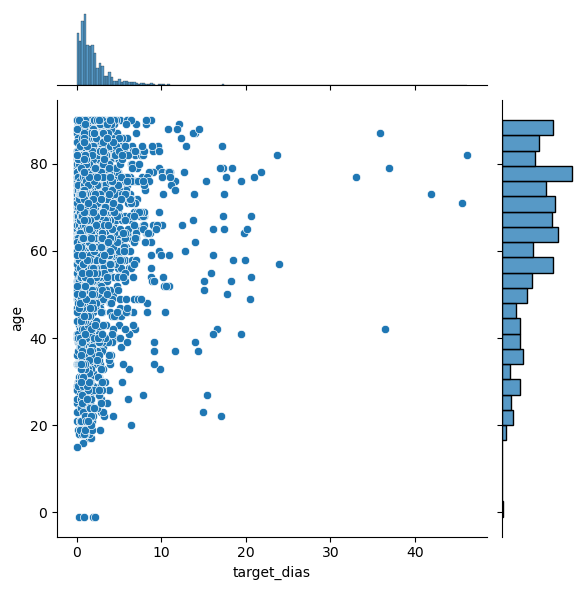

In [19]:
# Visualizar la correlación entre las columnas "total_bill" y "tip"
sns.jointplot(data=data, x='target_dias', y='age', kind='scatter')

In [20]:
dataGraf = data.copy()
dataGraf.pop('patientunitstayid')
dataGraf.pop('unitdischargeoffset')
corr_matrix = dataGraf.corr()

C:\Users\rauld\AppData\Local\Temp\ipykernel_16792\3390380869.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataGraf.corr()


Por último, un estudio de la correlación de algunas de las variables númericas del dataset Paciente con la variable paciente.

<AxesSubplot: >

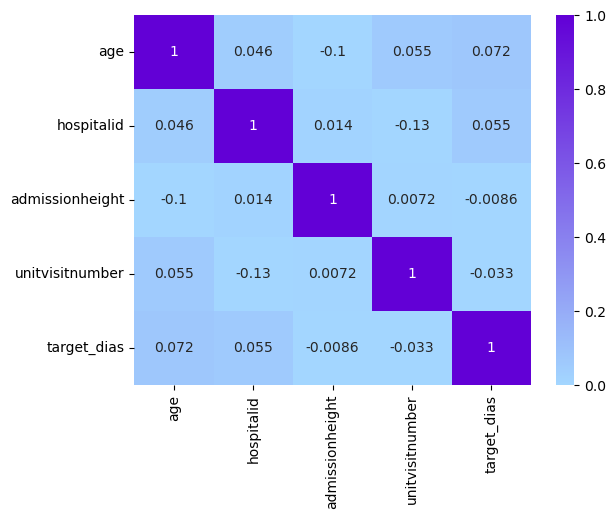

In [21]:
colors = [(163/255, 214/255, 255/255), (98/255, 0/255, 214/255)]
cmap = mcolors.LinearSegmentedColormap.from_list('Custom', colors, N=256)
# Generar el heatmap
sns.heatmap(corr_matrix, annot=True, cmap=cmap, vmin=0, vmax=1)

Como se observa en el heatmap no existe ninguna variable, a priori, que tenga mucha relación con la variable target. Es por esto, que decidimos para conocer de una forma sencilla la importancia de cada característica sin la necesidad de programar el preprocesado y el modelo de ML, utilizar el software WEKA para obtener un análisis más detallado de forma rápida. Dado que este software lo utilizamos también más adelante, expondré los resultos a la vez, una vez terminado el Feature Selection y Engineer.

# Past History Dataset
Pasamos a analizar y tratar los datos de los datasets que nos van a aportar más características al conjunto de datos de Patient. Empezamos con el historial clínico del paciente, según hemos podido leer en varios papers, las enfermedades que haya padecido el paciente tienen gran relevancia en el tratamiento y los cuidados que se les aplica durante su estancia en UCI.

## Carga dataset

In [22]:
past_history = pd.read_csv(ruta_datasets+"pastHistory.csv")

In [23]:
past_history.head()

,pasthistoryid,patientunitstayid,pasthistoryoffset,pasthistoryenteredoffset,pasthistorynotetype,pasthistorypath,pasthistoryvalue,pasthistoryvaluetext
0,990803,141765,7,12,Comprehensive Progress,notes/Progress Notes/Past History/Past History...,No Health Problems,NoHealthProblems
1,970059,143870,4,10,Comprehensive Progress,notes/Progress Notes/Past History/Past History...,No Health Problems,NoHealthProblems
2,1180401,144815,32,41,Comprehensive Progress,notes/Progress Notes/Past History/Past History...,No Health Problems,NoHealthProblems
3,1194998,145427,8,13,Comprehensive Progress,notes/Progress Notes/Past History/Past History...,No Health Problems,NoHealthProblems
4,896652,147307,53,56,Comprehensive Progress,notes/Progress Notes/Past History/Past History...,No Health Problems,NoHealthProblems


## Análisis Previo
En este apartado hemos llevado a cabo un análisis parecido al realizado sobre el dataset de Patient, y que se va a repetir en los siguiente documentos, así que no voy a repetir las explicaciones del código, pero si voy a citar ciertas obseraciones a tener en cuenta.

In [24]:
past_history.shape

(12109, 8)

In [25]:
past_history.dtypes

pasthistoryid                int64
patientunitstayid            int64
pasthistoryoffset            int64
pasthistoryenteredoffset     int64
pasthistorynotetype         object
pasthistorypath             object
pasthistoryvalue            object
pasthistoryvaluetext        object
dtype: object

Las variables númericas de este dataset no son ingluyentes según lo investigado, poseen el ID del paciente y algunos datos más de control de registro que no nos influyen en el estudio que estamos llevando a cabo.

In [26]:
past_history.describe()

,pasthistoryid,patientunitstayid,pasthistoryoffset,pasthistoryenteredoffset
count,1.210900e+04,1.210900e+04,12109.000000,12109.000000
mean,1.155916e+07,1.903050e+06,1033.009002,1116.320423
std,6.567584e+06,1.026370e+06,3055.118424,2857.771688
min,8.480350e+05,1.417650e+05,-42622.000000,-1933.000000
25%,5.955936e+06,1.054428e+06,16.000000,36.000000
50%,1.137201e+07,1.820689e+06,59.000000,101.000000
75%,1.666365e+07,2.883334e+06,607.000000,719.000000
max,2.235089e+07,3.353113e+06,28637.000000,28649.000000


Es interesante ver que en la característica que nos vamos a fijar "pasthistorypath", es la que contiene las enfermedades registradas en el historial clínico del paciente, hay 190 valores únicos, así que de primeras nos dice que exites cierto estándar.

In [27]:
past_history.describe(exclude=[np.number])

,pasthistorynotetype,pasthistorypath,pasthistoryvalue,pasthistoryvaluetext
count,12109,12109,12109,12109
unique,6,190,174,174
top,Admission,notes/Progress Notes/Past History/Past History...,Performed,Performed
freq,7096,2998,2998,2998


In [28]:
past_history.isnull().sum() / past_history.shape[0]

pasthistoryid               0.0
patientunitstayid           0.0
pasthistoryoffset           0.0
pasthistoryenteredoffset    0.0
pasthistorynotetype         0.0
pasthistorypath             0.0
pasthistoryvalue            0.0
pasthistoryvaluetext        0.0
dtype: float64

In [29]:
for col in past_history.columns[past_history.dtypes==object]:
    display((past_history.groupby([col]).size()/past_history.shape[0]).reset_index(name='counts'))

,pasthistorynotetype,counts
0,Admission,0.586010
1,Comprehensive Progress,0.304815
2,Follow-up Consultation/Other,0.015856
3,Initial Consultation/Other,0.005368
4,Past History Edit,0.056652
5,Re-Admission,0.031299


,pasthistorypath,counts
0,notes/Progress Notes/Past History/Organ System...,0.004212
1,notes/Progress Notes/Past History/Organ System...,0.004294
2,notes/Progress Notes/Past History/Organ System...,0.000083
3,notes/Progress Notes/Past History/Organ System...,0.000083
4,notes/Progress Notes/Past History/Organ System...,0.001074
...,...,...
185,notes/Progress Notes/Past History/Organ System...,0.000165
186,notes/Progress Notes/Past History/Past History...,0.019737
187,notes/Progress Notes/Past History/Past History...,0.002643
188,notes/Progress Notes/Past History/Past History...,0.001982


,pasthistoryvalue,counts
0,>= 20 mg prednisone per day or equivalent,0.000661
1,A paced,0.000495
2,A/V paced,0.001404
3,AICD,0.004212
4,ALL,0.000083
...,...,...
169,uterus,0.000578
170,varices,0.000908
171,ventricular ectopy,0.000495
172,ventricular fibrillation,0.000083


,pasthistoryvaluetext,counts
0,>= 20 mg prednisone per day or equivalent,0.000661
1,A paced,0.000495
2,A/V paced,0.001404
3,AICD,0.004212
4,ALL,0.000083
...,...,...
169,uterus,0.000578
170,varices,0.000908
171,ventricular ectopy,0.000495
172,ventricular fibrillation,0.000083


## Tratamiento Features
Tras un primer análisis lo que hemos decidido es dividir la columna del historial clinico en diferentes características usando el carácter '/' como delimitador de esta división, posteriormente, nos quedamos solo con la 4 posición de la división, ya que hemos observado que es la posición más específica que se define para todos los pacientes

In [30]:
past_history['pasthistorysplit'] = past_history['pasthistorypath'].str.split('/').str[4]

Como se observa en la siguiente instrucción nos hemos quedado con un grupo de variables que definen donde han tenido problemas los pacientes: Corazón, pulmones...

In [31]:
past_history['pasthistorysplit'].unique()

array(['No Health Problems', 'Performed', 'Endocrine (R)', 'Hematology',
       'Pulmonary', 'Cardiovascular (R)', 'Neurologic',
       'Infectious Disease (R)', 'Renal  (R)', 'Gastrointestinal (R)',
       'Rheumatic', 'Not Performed', 'Not Obtainable'], dtype=object)

In [32]:
past_history.isnull().sum() / past_history.shape[0]

pasthistoryid               0.0
patientunitstayid           0.0
pasthistoryoffset           0.0
pasthistoryenteredoffset    0.0
pasthistorynotetype         0.0
pasthistorypath             0.0
pasthistoryvalue            0.0
pasthistoryvaluetext        0.0
pasthistorysplit            0.0
dtype: float64


El siguiente paso es eliminar las categorías que no nos aportan valor, es decir, que no nos definen un problema.


In [33]:
past_history = past_history.loc[past_history['pasthistorysplit'] != 'No Health Problems', :]
past_history = past_history.loc[past_history['pasthistorysplit'] != 'Performed', :]
past_history = past_history.loc[past_history['pasthistorysplit'] != 'Not Performed', :]
past_history = past_history.loc[past_history['pasthistorysplit'] != 'Not Obtainable', :]

In [34]:
past_history['pasthistorysplit'].unique()

array(['Endocrine (R)', 'Hematology', 'Pulmonary', 'Cardiovascular (R)',
       'Neurologic', 'Infectious Disease (R)', 'Renal  (R)',
       'Gastrointestinal (R)', 'Rheumatic'], dtype=object)

In [35]:
past_history = past_history[['pasthistoryid', 'patientunitstayid', 'pasthistorysplit']]

In [36]:
past_history.shape

(8816, 3)

In [37]:
past_history.pivot_table('pasthistorysplit', index=['patientunitstayid'], aggfunc='count')

,pasthistorysplit
patientunitstayid,
147784,1
151179,2
151900,4
153972,8
155961,1
...,...
3351763,6
3352230,6
3352231,2


Por último, vamos a dejar preparado los datos de este dataset para ser megeados(unidos) con los de paciente. Vamos a definir una tabla por ID de paciente y una columna por cada una de las categorías obtenidas en los pasos anteriores, en las diferentes observaciones, vamos a definir con un '1' si el paciente a tenido registro en su historial clínico de una enfermedad de esa categoría o '0' para el caso contrario.

In [38]:
paciente_pastHistory = pd.DataFrame({'patientunitstayid': past_history['patientunitstayid'].unique()})
paciente_pastHistory.head()

,patientunitstayid
0,147784
1,151179
2,151900
3,153972
4,155961


In [39]:
pivot_table = pd.pivot_table(past_history, index='patientunitstayid', columns='pasthistorysplit', values='pasthistoryid', aggfunc=lambda x: 1)

In [40]:
paciente_pastHistory = paciente_pastHistory.merge(pivot_table, on='patientunitstayid', how='left').fillna(0)

In [41]:
paciente_pastHistory.head()

,patientunitstayid,Cardiovascular (R),Endocrine (R),Gastrointestinal (R),Hematology,Infectious Disease (R),Neurologic,Pulmonary,Renal (R),Rheumatic
0,147784,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,151179,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,151900,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,153972,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,155961,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
paciente_pastHistory.shape

(1838, 10)

# Vital Periodic
En este caso, vamos a estudiar el modelo de datos de medidas vitales periódicas. En este dataset, tenemos varias medidas que se toman automáticamente cada 5 minutos. Vamos a estudiar este dataset y exponer como hemos decidido tratar estas variables

## Carga dataset

In [43]:
vital_periodic = pd.read_csv(ruta_datasets+"vitalPeriodic.csv")

In [44]:
vital_periodic.head()

,vitalperiodicid,patientunitstayid,observationoffset,temperature,sao2,heartrate,respiration,cvp,etco2,systemicsystolic,systemicdiastolic,systemicmean,pasystolic,padiastolic,pamean,st1,st2,st3,icp
0,29524122,141765,1179,NaN,NaN,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29557845,141765,189,NaN,97.0,76.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29524442,141765,1169,NaN,NaN,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29513052,141765,1534,NaN,NaN,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29524600,141765,1164,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Análisis Previo

In [45]:
vital_periodic.shape

(1634960, 19)

Como vemos tenemos medidas muy interesantes y variadas como saturación de oxigeno, pulsaciones por minuto, temperatura...Según hemos leído en diferenes artículos estas medidas suelen tener una correlación alta con la gravedad del paciente, y por tanto, la estancia en la UCI.

In [46]:
vital_periodic.dtypes

vitalperiodicid        int64
patientunitstayid      int64
observationoffset      int64
temperature          float64
sao2                 float64
heartrate            float64
respiration          float64
cvp                  float64
etco2                float64
systemicsystolic     float64
systemicdiastolic    float64
systemicmean         float64
pasystolic           float64
padiastolic          float64
pamean               float64
st1                  float64
st2                  float64
st3                  float64
icp                  float64
dtype: object

In [47]:
vital_periodic.describe()

,vitalperiodicid,patientunitstayid,observationoffset,temperature,sao2,heartrate,respiration,cvp,etco2,systemicsystolic,systemicdiastolic,systemicmean,pasystolic,padiastolic,pamean,st1,st2,st3,icp
count,1.634960e+06,1.634960e+06,1.634960e+06,112820.000000,1.441700e+06,1.627894e+06,1.381351e+06,202284.000000,72780.000000,226475.000000,226471.000000,228400.000000,32083.000000,32080.000000,32632.000000,613267.000000,656963.000000,596372.000000,13193.000000
mean,1.073732e+09,1.763917e+06,5.430636e+03,38.677957,9.645519e+01,8.546431e+01,2.011894e+01,36.530358,29.464427,124.276839,59.338816,80.989046,37.089175,18.766022,26.203205,1.541094,2.990486,3.120847,7.416888
std,6.632675e+08,1.002795e+06,8.165811e+03,9.780907,4.725472e+00,1.809112e+01,6.694569e+00,77.848130,12.078326,25.743627,15.681670,19.742098,12.357919,8.417253,10.501996,15.407413,28.562166,34.591758,7.095089
min,7.147800e+04,1.417640e+05,-2.843000e+03,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,-50.000000,0.000000,-44.000000,-76.000000,-45.000000,-1.000000,-7.000000,-6.000000,-12.750000,-12.000000,-12.600000,-23.000000
25%,5.010690e+08,9.614400e+05,9.970000e+02,36.700000,9.500000e+01,7.200000e+01,1.600000e+01,7.000000,26.000000,107.000000,49.000000,69.000000,29.000000,14.000000,20.000000,-0.200000,-0.300000,-0.200000,4.000000
50%,1.116957e+09,1.733366e+06,2.506000e+03,37.200000,9.700000e+01,8.400000e+01,1.900000e+01,12.000000,30.000000,122.000000,57.000000,78.000000,35.000000,18.000000,25.000000,0.000000,0.000000,0.000000,8.000000
75%,1.662587e+09,2.742660e+06,6.129000e+03,37.700000,9.900000e+01,9.700000e+01,2.300000e+01,18.000000,36.000000,140.000000,67.000000,89.000000,44.000000,23.000000,31.000000,0.160000,0.300000,0.200000,11.000000
max,2.188309e+09,3.353113e+06,6.647300e+04,103.000000,1.000000e+02,2.570000e+02,1.880000e+02,400.000000,194.000000,349.000000,344.000000,353.000000,316.000000,316.000000,316.000000,520.000000,1190.000000,1200.000000,276.000000


Como vemos en la siguiente instrucción tenemos varias características con un porcentaje de valores nulos por encima del 60%, por tanto, hemos decidido quedarnos con las siguientes variables:
- Sao2 = saturación de oxígeno
- Heartrate = pulsaciones
- Respiration = respiración asistida

In [48]:
vital_periodic.isnull().sum() / vital_periodic.shape[0]

vitalperiodicid      0.000000
patientunitstayid    0.000000
observationoffset    0.000000
temperature          0.930995
sao2                 0.118205
heartrate            0.004322
respiration          0.155116
cvp                  0.876276
etco2                0.955485
systemicsystolic     0.861480
systemicdiastolic    0.861482
systemicmean         0.860302
pasystolic           0.980377
padiastolic          0.980379
pamean               0.980041
st1                  0.624904
st2                  0.598178
st3                  0.635238
icp                  0.991931
dtype: float64

In [49]:
for col in vital_periodic.columns[vital_periodic.dtypes==object]:
    display((vital_periodic.groupby([col]).size()/vital_periodic.shape[0]).reset_index(name='counts'))

## Tratamiento de Features

In [50]:
vital_periodic = vital_periodic[['vitalperiodicid', 'patientunitstayid', 'sao2', 'heartrate', 'respiration']]

In [51]:
vital_periodic.shape

(1634960, 5)

Como hemos comentado anteiormente solo nos hemos quedado con 3 características por la cantidad de valores nulos, pero eso no quita, que las elegidas también tuvieran valores nulos. Lo que hemos hecho para tratar estos valores nulos es sustituirlos por el valor medio de ese valor para cada paciente, es decir, no el valor medio total, sino con respecto al nivel paciente.

In [52]:
vital_periodic.fillna(vital_periodic.groupby('patientunitstayid').transform('mean'), inplace=True)

Por último, preparamos los datos para unirlos con el dataset de Pacientes. En este caso debido a nuestro limitaod conocimiento médico hemos optados por curarnos en salud y sacar de cada característica el valor mínimo, medio y máximo de cada paciente durante su estancia en la UCI.

In [53]:
patient_vital_periodic = vital_periodic.groupby('patientunitstayid').agg({'sao2': ['min', 'max', 'mean'],
                                                          'heartrate': ['min', 'max', 'mean'],
                                                          'respiration': ['min', 'max', 'mean']})

In [54]:
patient_vital_periodic.columns = ['_'.join(col).strip() for col in patient_vital_periodic.columns.values]
patient_vital_periodic.head()

,sao2_min,sao2_max,sao2_mean,heartrate_min,heartrate_max,heartrate_mean,respiration_min,respiration_max,respiration_mean
patientunitstayid,,,,,,,,,
141764,NaN,NaN,NaN,90.0,138.0,106.652174,NaN,NaN,NaN
141765,95.0,98.0,96.611374,72.0,138.0,87.017817,17.0,39.0,24.782609
143870,80.0,100.0,96.284810,40.0,55.0,45.449367,45.0,86.0,67.031646
144815,96.0,100.0,98.630682,68.0,118.0,83.800000,6.0,42.0,16.927273
145427,89.0,100.0,95.761905,49.0,85.0,65.457983,5.0,41.0,16.349206


In [55]:
mean_values = patient_vital_periodic.mean()
mean_values

sao2_min             81.293562
sao2_max             99.474249
sao2_mean            96.165080
heartrate_min        62.310491
heartrate_max       112.738579
heartrate_mean       83.728775
respiration_min       8.898705
respiration_max      36.060130
respiration_mean     19.628618
dtype: float64

In [56]:
patient_vital_periodic.fillna(mean_values, inplace=True)
patient_vital_periodic.head()

,sao2_min,sao2_max,sao2_mean,heartrate_min,heartrate_max,heartrate_mean,respiration_min,respiration_max,respiration_mean
patientunitstayid,,,,,,,,,
141764,81.293562,99.474249,96.165080,90.0,138.0,106.652174,8.898705,36.06013,19.628618
141765,95.000000,98.000000,96.611374,72.0,138.0,87.017817,17.000000,39.00000,24.782609
143870,80.000000,100.000000,96.284810,40.0,55.0,45.449367,45.000000,86.00000,67.031646
144815,96.000000,100.000000,98.630682,68.0,118.0,83.800000,6.000000,42.00000,16.927273
145427,89.000000,100.000000,95.761905,49.0,85.0,65.457983,5.000000,41.00000,16.349206


# Hospital Dataset

El siguiente dataset utilizado es el que posee información de cada hospital: número de camas, región, estado. Creemos importannte señalar en que hospital ha estado cada paciente, porque se puede dar la posibilidad de que cada hospital tenga una política de procedimiento UCI diferente.

## Carga dataset

In [57]:
hospital = pd.read_csv(ruta_datasets+"hospital.csv")

In [58]:
hospital.head()

,hospitalid,numbedscategory,teachingstatus,region
0,56,<100,f,Midwest
1,58,100 - 249,f,Midwest
2,59,<100,f,Midwest
3,60,<100,f,Midwest
4,61,<100,f,Midwest


## Análisis Previo

In [59]:
hospital.shape

(186, 4)

In [60]:
hospital.dtypes

hospitalid          int64
numbedscategory    object
teachingstatus     object
region             object
dtype: object

In [61]:
hospital.describe()

,hospitalid
count,186.000000
mean,269.483871
std,118.084588
min,56.000000
25%,176.750000
50%,263.500000
75%,387.750000
max,459.000000


In [62]:
hospital.describe(exclude=[np.number])  

,numbedscategory,teachingstatus,region
count,158,186,168
unique,4,2,4
top,100 - 249,f,Midwest
freq,61,168,62


In [63]:
hospital.isnull().sum() / hospital.shape[0]

hospitalid         0.000000
numbedscategory    0.150538
teachingstatus     0.000000
region             0.096774
dtype: float64

Como se puede observar en este análisis el número de camas no se establece por un número fijo, sino por categorías ordindales de capacidad, donde lo más común es que un hotel tenga de 100-249 camas dedicadas a UCI.

In [64]:
for col in hospital.columns[hospital.dtypes==object]:
    display((hospital.groupby([col]).size()/hospital.shape[0]).reset_index(name='counts'))

,numbedscategory,counts
0,100 - 249,0.327957
1,250 - 499,0.188172
2,<100,0.209677
3,>= 500,0.123656


,teachingstatus,counts
0,f,0.903226
1,t,0.096774


,region,counts
0,Midwest,0.333333
1,Northeast,0.069892
2,South,0.290323
3,West,0.209677


## Tratamiento Features
Para preparar los datos para la unión con el dataset de Pacientes hemos elegido el ID del hospital y el número de camas, es decir, la capacidad. Hemos sustituido los valores nulos de la segunda por el valor más frecuente(moda) y sustituir las categorías por un valor númerico que pueda entender el modelo de ML, y que vaya en orden de mayor a menor según la capacidad de cada hospital.

In [65]:
hospital = hospital[['hospitalid', 'numbedscategory']]

In [66]:
mode_values = hospital.mode().iloc[0]
mode_values

hospitalid                56
numbedscategory    100 - 249
Name: 0, dtype: object

In [67]:
hospital.fillna(mode_values, inplace=True)

In [68]:
hospital['numbedscategory'] = hospital['numbedscategory'].replace({'100 - 249': 1, '250 - 499':2 , '<100': 3, '>= 500':4})

In [69]:
hospital['numbedscategory'].unique()

array([3, 1, 4, 2], dtype=int64)

In [70]:
hospital.head()

,hospitalid,numbedscategory
0,56,3
1,58,1
2,59,3
3,60,3
4,61,3


# Respiratory Charting
En este dataset hay información de la respiración asistida que ha necesitado cada paciente, por simplificar el modelo de datos final, y para no cometer un error seleccionando las variables por nuestro desconocimiento médico, hemos decidido agrupar el dataset por los IDs de paciente que hay y al unirlos con el dataset de paciente, añadiremos una columna con un '1' si el paciente ha necesitado respiración asistida o un '0' si no lo ha necesitado.

## Carga dataset

In [71]:
resCharting = pd.read_csv(ruta_datasets+"respiratoryCharting.csv")

In [72]:
resCharting.head()

,respchartid,patientunitstayid,respchartoffset,respchartentryoffset,respcharttypecat,respchartvaluelabel,respchartvalue
0,107,184757,2922,2922,respFlowSettings,LPM O2,1
1,1108,187150,408,408,respFlowSettings,FiO2,80
2,10629,179269,117,117,respFlowSettings,LPM O2,6
3,13000,162502,3845,3845,respFlowSettings,LPM O2,25
4,13001,162502,3845,3845,respFlowSettings,FiO2,60


## Análisis Previo

In [73]:
resCharting.shape

(176089, 7)

In [74]:
resCharting.dtypes

respchartid              int64
patientunitstayid        int64
respchartoffset          int64
respchartentryoffset     int64
respcharttypecat        object
respchartvaluelabel     object
respchartvalue          object
dtype: object

In [75]:
resCharting.describe()

,respchartid,patientunitstayid,respchartoffset,respchartentryoffset
count,1.760890e+05,1.760890e+05,176089.000000,176089.000000
mean,1.260332e+08,1.891008e+06,7168.550244,7184.081419
std,7.654253e+07,1.026092e+06,9498.976967,9493.894538
min,1.070000e+02,1.438700e+05,-24147.000000,-24147.000000
25%,5.667673e+07,9.100500e+05,1181.000000,1197.000000
50%,1.352144e+08,1.998890e+06,3826.000000,3839.000000
75%,1.863991e+08,2.873230e+06,9481.000000,9484.000000
max,2.555675e+08,3.352333e+06,74892.000000,74892.000000


In [76]:
resCharting.describe(exclude=[np.number])  

,respcharttypecat,respchartvaluelabel,respchartvalue
count,176089,176089,176069
unique,3,172,2661
top,respFlowSettings,FiO2,5
freq,94767,27432,12021


In [77]:
resCharting.isnull().sum() / resCharting.shape[0]

respchartid             0.000000
patientunitstayid       0.000000
respchartoffset         0.000000
respchartentryoffset    0.000000
respcharttypecat        0.000000
respchartvaluelabel     0.000000
respchartvalue          0.000114
dtype: float64

In [78]:
for col in resCharting.columns[resCharting.dtypes==object]:
    display((resCharting.groupby([col]).size()/resCharting.shape[0]).reset_index(name='counts'))

,respcharttypecat,counts
0,respFlowCareData,0.107309
1,respFlowPtVentData,0.354514
2,respFlowSettings,0.538177


,respchartvaluelabel,counts
0,5. ARDS Eval (M or DNM),0.000006
1,A1: High Exhaled Vt,0.000341
2,AIRWAY TEMPERATURE,0.000011
3,Adult Con Alarms Backup I:E,0.000045
4,Adult Con Alarms Backup PC,0.000045
...,...,...
167,WUA Patient Response/RASS Score,0.000045
168,Wake up assessment interventions,0.000051
169,Wake up assessment performed,0.000017
170,Weaning Assessment Criteria Collaboration,0.000023


,respchartvalue,counts
0,(4),0.000068
1,-1,0.000006
2,-2,0.000693
3,-3,0.000006
4,0,0.023136
...,...,...
2656,Y,0.002629
2657,Yellow,0.000017
2658,Yes,0.013289
2659,cmH2O,0.000108


## Tratamiento Features

In [79]:
resCharting = resCharting[['respchartid', 'patientunitstayid']]

Con este dataset terminamos el Feature Selection y Engineer del que hablabamos en el primer análisis, si es verdad que hay otros datasets importantes y que no se ha extraído todo el jugo de los que se han tratado, pero dado el tiempo disponible lo creemos más que suficiente para exponer la solución definida y sustentarla ante el jurado de la competición con unos datos y métricas buenas.

Para entrar más en específico y exponer los resultados de este proceso de una forma más visual, he desarrollado la siguiente diapositiva:

<img src="./img/Feature Selection.PNG">

Como se observa en la diapositiva pasamos de 31 tablas en el modelo relacional a 11 tablas. A partir de dichas tablas se ha realizado el Feature Selection, donde hemos escogido las características que nos iban, a priori, a ayudar más en nuestro estudio, y hemos realizado diferentes procesos de Feature Engineer y Feature Transformation para adaptar estas características al dataset de pacientes.

# Preprocesado Modelo de datos Final



## Merge Datasets con Patient

El siguiente paso para continuar con el estudio, es unir cada dataset tranformado con el de pacientes final, esta tarea se lleva a cabo de forma sencilla, ya que hemos preparado los datasets de cada tabla para está unión en el último paso de cada preprocesado anterior.

In [80]:
data.shape

(2520, 12)

In [81]:
# Merge patient con pasthistory
data_v2 = pd.merge(data, paciente_pastHistory, on='patientunitstayid', how='left')

In [82]:
#Comprobacion de merge correcto
data_v2.shape

(2520, 21)

In [83]:
# Merge patient con vitalperiodic
data_v3 = pd.merge(data_v2, patient_vital_periodic, on='patientunitstayid', how='left')

In [84]:
#Comprobacion de merge correcto
data_v3.shape

(2520, 30)

In [85]:
# Merge patient con hospital
data_v4 = pd.merge(data_v3, hospital, on='hospitalid', how='left')

In [86]:
#Comprobacion de merge correcto
data_v4.shape

(2520, 31)

In [87]:
# Merge patient con respiratory Charting
data_v4['en_resCharting'] = data_v4['patientunitstayid'].isin(resCharting['patientunitstayid']).astype(int)

In [88]:
#Comprobacion de merge correcto
data_v4.shape

(2520, 32)

Una vez que tenemos un dataset único hemos decidido hacer el segundo estudio con WEKA para valorar la importancia de las diferentes variables en modelos sencillos. Como comenté anteriormente, este software lo hemos utilizado en dos puntos diferentes del caso de uso, después del primer análisis del target, y una vez que tenemos el dataset final, el cual vamos a utilizar para entrenar nuestro modelo de ML. En la siguiente diapositva, se observa el resultado de los dos modelos:

<img src="./img/WEKA.PNG">


Como se observa, en el primer modelo, la variable más importante es Apache Admission, que en resumen es la patología con la que es admitido el paciente en la UCI. APACHE es un estandar que según hemos podido comprobar define un puntaje que intenta cuantificar la esperanza de vida de un paciente, en este caso como he citado es la enfermedad con la que es admitado el paciente. 

En el segundo gráfico se observa que ha surgido efecto los procesos de Feature Selection y Engineer llevados a cabo, por que son esas features las que toman gran importancia en el modelo.

## Taking Care of Missing Data
A partir de aquí, empezamos con la última parte del procesado de los datos antes de entrenar el modelo, el preprocesado "real", es decir, el preprocesado del conjunto final de los datos. En la siguiente diapositiva se explica que se ha realizado durante este proceso, que en la siguientes celdas se puede observar:

<img src="./img/Preprocesado.PNG">

En resumen, el preprocesado se divide en:

- **Corrección de la distribución de la algunas características** para que sigan una distribución normal


- **Eliminación de observaciones**, por ejemplo aquellas donde el target de minutos era igual a 0, es decir, datos erróneos que puede confundir al modelo


- **Correción de formato**


- **Tratamiento de datos faltantes**, tanto de los valores númericos como de los categóricos


- **Codificación de las variables categóricas** siguiendo las reglas del Count Enconding, ya que algunas de ellas tienen más de 200 categorias y si siguieramos una codificación One Hot Encoding (común) el número de características crecería exponencialmente.

Todos estos procesos han resultado en que el dataset final tenga 2167 observaciones con las que hemos entrenado un modelo de predicción.

### Primeros cambios preestablecidos

In [89]:
data_v4.dtypes

patientunitstayid           int64
gender                     object
age                         int32
hospitalid                  int64
apacheadmissiondx          object
admissionheight           float64
unittype                   object
unitadmitsource            object
unitvisitnumber             int64
unitstaytype               object
unitdischargeoffset         int64
target_dias               float64
Cardiovascular (R)        float64
Endocrine (R)             float64
Gastrointestinal (R)      float64
Hematology                float64
Infectious Disease (R)    float64
Neurologic                float64
Pulmonary                 float64
Renal  (R)                float64
Rheumatic                 float64
sao2_min                  float64
sao2_max                  float64
sao2_mean                 float64
heartrate_min             float64
heartrate_max             float64
heartrate_mean            float64
respiration_min           float64
respiration_max           float64
respiration_me

In [90]:
data_v5 = data_v4.loc[data_v4['unitstaytype'] != 'stepdown/other']

In [91]:
data_v6 = data_v5.loc[~data_v5['apacheadmissiondx'].isna()]

In [92]:
data_v6 = data_v6.drop('unitstaytype', axis=1)

In [93]:
data_v6.shape

(2161, 31)

In [94]:
target = data_v6.pop('unitdischargeoffset')
data_v6 = data_v6.assign(columna=target)
data_v6 = data_v6.rename(columns={'columna': 'target'})

In [95]:
data_v6.isnull().sum() / data_v6.shape[0]

patientunitstayid         0.000000
gender                    0.001388
age                       0.000000
hospitalid                0.000000
apacheadmissiondx         0.000000
admissionheight           0.018047
unittype                  0.000000
unitadmitsource           0.001851
unitvisitnumber           0.000000
target_dias               0.000000
Cardiovascular (R)        0.180935
Endocrine (R)             0.180935
Gastrointestinal (R)      0.180935
Hematology                0.180935
Infectious Disease (R)    0.180935
Neurologic                0.180935
Pulmonary                 0.180935
Renal  (R)                0.180935
Rheumatic                 0.180935
sao2_min                  0.022212
sao2_max                  0.022212
sao2_mean                 0.022212
heartrate_min             0.022212
heartrate_max             0.022212
heartrate_mean            0.022212
respiration_min           0.022212
respiration_max           0.022212
respiration_mean          0.022212
numbedscategory     

### Categorical Features

In [96]:
data_v6.select_dtypes(np.object_).loc[:, data_v6.isna().sum() > 0].columns

Index(['gender', 'unitadmitsource'], dtype='object')

In [97]:
data_v6['gender'] = data_v6['gender'].fillna('Other')

In [98]:
moda_edad = data_v6['unitadmitsource'].mode()[0]
data_v6['unitadmitsource'] = data_v6['unitadmitsource'].fillna(moda_edad)

### Numerical Features

In [99]:
media = data_v6.loc[data_v6['age'] != -1, 'age'].mean()
data_v6['age'] = data_v6['age'].replace(-1, media)

In [100]:
data_v6.select_dtypes(np.number).loc[:, data_v6.isna().sum() > 0].columns

Index(['admissionheight', 'Cardiovascular (R)', 'Endocrine (R)',
       'Gastrointestinal (R)', 'Hematology', 'Infectious Disease (R)',
       'Neurologic', 'Pulmonary', 'Renal  (R)', 'Rheumatic', 'sao2_min',
       'sao2_max', 'sao2_mean', 'heartrate_min', 'heartrate_max',
       'heartrate_mean', 'respiration_min', 'respiration_max',
       'respiration_mean'],
      dtype='object')

In [101]:
def knn_impute (df, column_na):
  df = df.copy()

  numeric_df = df.select_dtypes(np.number)
  non_na_columns = numeric_df.loc[: , numeric_df.isna().sum() == 0].columns

  y_train = numeric_df.loc[numeric_df[column_na].isna() == False, column_na]
  X_train = numeric_df.loc[numeric_df[column_na].isna() == False, non_na_columns]
  X_test = numeric_df.loc[numeric_df[column_na].isna() == True, non_na_columns]

  knn = KNeighborsRegressor()
  knn.fit(X_train, y_train)

  y_pred = knn.predict(X_test)

  df.loc[df[column_na].isna() == True, column_na] = y_pred

  return df

In [102]:
data_v6 = knn_impute(data_v6, 'admissionheight')

In [103]:
data_v6 = knn_impute(data_v6, 'sao2_min')

In [104]:
data_v6 = knn_impute(data_v6, 'sao2_max')

In [105]:
data_v6 = knn_impute(data_v6, 'sao2_mean')

In [106]:
data_v6 = knn_impute(data_v6, 'heartrate_min')

In [107]:
data_v6 = knn_impute(data_v6, 'heartrate_mean')

In [108]:
data_v6 = knn_impute(data_v6, 'heartrate_max')

In [109]:
data_v6 = knn_impute(data_v6, 'respiration_min')

In [110]:
data_v6 = knn_impute(data_v6, 'respiration_max')

In [111]:
data_v6 = knn_impute(data_v6, 'respiration_mean')

In [112]:
data_v6 = data_v6.fillna(0)

In [113]:
data_v6.select_dtypes(np.number).loc[:, data_v6.isna().sum() > 0].columns

Index([], dtype='object')

## Feature Transforming

### Obtener dias
Es importante comentar este paso que hemos realizado antes de entrenar el modelo, que tiene que ver con la solución final buscada, como expondré más adelante, la solución planteada posee dos modelos, uno de ellos para clasificar a los pacientes en duración de menos o igual a 3 días y más de 3 días. Posteriormente, los pacientes clasificados como duración menor o igual a 3 días pasarán por un modelo de regresión para obtener el número de horas que estarán. Por tanto, vamos a añadir una columna que establezca una las dos categorías a clasificar 0 o 1.

Una de las dudas que puede surgir es el porque de tomar 3 días como barrera de corte, dado que nuestro conocimientos médicos no son extensos, nos hemos guiado por el percentil 75 de la variable target en días.

In [114]:
data_v6['target_dias'] = data_v6['target']/1440

In [115]:
data_v6_2cat = data_v6.copy()

In [116]:
data_v6_2cat.loc[data_v6_2cat['target_dias']<= 3, ['target_dias']] = 0
data_v6_2cat.loc[data_v6_2cat['target_dias']> 3, ['target_dias']] = 1

In [117]:
data_v6.to_csv(ruta_datasets+"datosResultantes.csv")

### Transform numeric features with skew normal distribution

In [118]:
#skew_df = pd.DataFrame(data_v6.select_dtypes(np.number).columns, columns=['Feature'])
#skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data_v6[feature]))
#skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
#skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x>=0.5 else False)
#skew_df

In [119]:
#for column in ['age', 'admissionheight', 'sao2_min', 'sao2_max', 'sao2_mean', 'respiration_max']:
#  data_v6[column] = np.log1p(data_v6[column])

## Encoding Categorical

In [120]:
#data_v7 = pd.get_dummies(data_v6, columns=['gender', 'apacheadmissiondx', 'unittype','unitadmitsource'])

In [121]:
columns_categorical=['gender', 'apacheadmissiondx', 'unittype','unitadmitsource']
count_encoder = CountEncoder()
count_encoder.fit(data_v6_2cat[columns_categorical])
encoded_data = count_encoder.transform(data_v6_2cat[columns_categorical])
data_v7 = data_v6_2cat.drop(columns_categorical, axis=1)
data_v7 = pd.concat([data_v7, encoded_data], axis=1)

In [122]:
data_v7.shape

(2161, 31)

In [123]:
data_v7.head()

,patientunitstayid,age,hospitalid,admissionheight,unitvisitnumber,target_dias,Cardiovascular (R),Endocrine (R),Gastrointestinal (R),Hematology,...,respiration_min,respiration_max,respiration_mean,numbedscategory,en_resCharting,target,gender,apacheadmissiondx,unittype,unitadmitsource
1,141765,87.0,59,157.5,1,0.0,0.0,0.0,0.0,0.0,...,17.0,39.0,24.782609,3,0,2250,847,78,1620,1225
2,143870,76.0,68,167.0,1,0.0,0.0,0.0,0.0,0.0,...,45.0,86.0,67.031646,3,1,793,1311,26,71,250
3,144815,34.0,56,172.7,1,0.0,0.0,0.0,0.0,0.0,...,6.0,42.0,16.927273,3,0,1121,847,14,1620,1225
4,145427,61.0,68,177.8,1,0.0,0.0,0.0,0.0,0.0,...,5.0,41.0,16.349206,3,1,1369,1311,13,71,250
6,147307,55.0,63,157.5,1,0.0,0.0,0.0,0.0,0.0,...,12.0,33.0,20.025641,1,1,476,847,26,1620,250


## Split Train and Validation Data
Antes de entrenar un modelo obviamente hay que hacer dos últimos pasos, eliminar los IDs de los pacientes que no aportan ningun valor al modelo y separar los conjuntos de datos en entrenamiento y validación y/o test.

In [124]:
data_v7.pop('patientunitstayid')
data_v7.pop('target')
target = data_v7.pop('target_dias')

In [125]:
X_train, X_test, y_train, y_test = train_test_split(data_v7, target, test_size=0.2, random_state=42)

# Train and Validation Model - Clasificacion en periodos

Como ya he adelantado antes el modelo va a seguir el siguiente flujo:

<img src="./img/Solucion Practica.PNG">

Primero se clasificará en dos grupos, los que vayan a estar más de 3 dias en la UCI o los que estarán 3 días o menos. Estos últimos pasarán por un segundo modelo de regresión para calcular el tiempo de estancia en horas.

## Classifier - XGBoost

Para la clasificación se han probado dos modelos (Radom Forest y XGBoost), y se ha decidido hacer tunnig de hiperparámetros con Grid Search para el que mejor a funcionado con el modelo base, que es el XGBoost Classifier. Dado el poco tiempo que teníamos no hemos podido profundizar todo lo que quisieramos en la elección de modelos y en el tunning de hiperparámetros, aún así hemos obtenido unos resultados que creemos positivos

In [126]:
modelo = XGBClassifier(n_estimators=500, max_depth=3, learning_rate=0.01, gamma=5)

In [127]:
param_grid = {
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
    'min_child_weight': [0, 1, 5, 10]
}

grid_search = GridSearchCV(modelo, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8267898383371824


In [128]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Validation Model XGBoost

Como creemos más importante que falle "de menos" en la clasificación de menos o igual a 3 días, hemos realizado un ajuste en el umbral de sensibilidad, aumentando el acierto a un 88% en la clasificación de paciente de <=3días.

In [129]:
modelo.fit(X_train, y_train)
y_pred_proba = modelo.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.35).astype(int)

In [130]:
cm=confusion_matrix(y_test, y_pred)

In [131]:
cm[0,0] / (cm[0,0]+cm[1,0])

0.8867313915857605

In [132]:
importances = modelo.feature_importances_

# Imprimir la importancia de cada variable
for i in range(len(importances)):
    print(f'Variable {i}: {importances[i]}')

Variable 0: 0.03959211707115173
Variable 1: 0.03113166242837906
Variable 2: 0.029247039929032326
Variable 3: 0.0
Variable 4: 0.024079684168100357
Variable 5: 0.0
Variable 6: 0.0
Variable 7: 0.026427684351801872
Variable 8: 0.0
Variable 9: 0.0
Variable 10: 0.0
Variable 11: 0.04041332006454468
Variable 12: 0.0
Variable 13: 0.14036545157432556
Variable 14: 0.06609632819890976
Variable 15: 0.04732464253902435
Variable 16: 0.06930377334356308
Variable 17: 0.09669391065835953
Variable 18: 0.038507942110300064
Variable 19: 0.04251446947455406
Variable 20: 0.08328305929899216
Variable 21: 0.03726497292518616
Variable 22: 0.035181865096092224
Variable 23: 0.07168083637952805
Variable 24: 0.0
Variable 25: 0.03335084021091461
Variable 26: 0.0
Variable 27: 0.047540485858917236


## Classifier - Random Forest 

In [133]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

## Validation Model

In [134]:
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.35).astype(int)

In [135]:
cm=confusion_matrix(y_test, y_pred)

In [136]:
cm[0,0] / (cm[0,0]+cm[1,0])

0.8567073170731707

In [137]:
cm

array([[281,  34],
       [ 47,  71]], dtype=int64)

# Train and Validation 2nd Model

In [138]:
#Transformación de la variable target
data_v6_regres = data_v6.drop(data_v6.loc[data_v6['target_dias'] > 3].index)

In [139]:
data_v6_regres.describe()['target_dias']

count    1634.000000
mean        1.339722
std         0.742474
min         0.000000
25%         0.780903
50%         1.173958
75%         1.878125
max         2.995833
Name: target_dias, dtype: float64

## Encoding Categorical

In [140]:
columns_categorical=['gender', 'apacheadmissiondx', 'unittype','unitadmitsource']
count_encoder = CountEncoder()
count_encoder.fit(data_v6_regres[columns_categorical])
encoded_data = count_encoder.transform(data_v6_regres[columns_categorical])
data_v7_regres = data_v6_regres.drop(columns_categorical, axis=1)
data_v7_regres = pd.concat([data_v7_regres, encoded_data], axis=1)

In [141]:
data_v7_regres.shape

(1634, 31)

In [142]:
data_v7_regres.head()

,patientunitstayid,age,hospitalid,admissionheight,unitvisitnumber,target_dias,Cardiovascular (R),Endocrine (R),Gastrointestinal (R),Hematology,...,respiration_min,respiration_max,respiration_mean,numbedscategory,en_resCharting,target,gender,apacheadmissiondx,unittype,unitadmitsource
1,141765,87.0,59,157.5,1,1.562500,0.0,0.0,0.0,0.0,...,17.0,39.0,24.782609,3,0,2250,631,65,1232,964
2,143870,76.0,68,167.0,1,0.550694,0.0,0.0,0.0,0.0,...,45.0,86.0,67.031646,3,1,793,1000,26,54,198
3,144815,34.0,56,172.7,1,0.778472,0.0,0.0,0.0,0.0,...,6.0,42.0,16.927273,3,0,1121,631,13,1232,964
4,145427,61.0,68,177.8,1,0.950694,0.0,0.0,0.0,0.0,...,5.0,41.0,16.349206,3,1,1369,1000,11,54,198
6,147307,55.0,63,157.5,1,0.330556,0.0,0.0,0.0,0.0,...,12.0,33.0,20.025641,1,1,476,631,26,1232,198


## Split Train and Validation Data

In [143]:
data_v7_regres.pop('patientunitstayid')
data_v7_regres.pop('target')
target = data_v7_regres.pop('target_dias')

In [144]:
X_trainR, X_testR, y_trainR, y_testR = train_test_split(data_v7_regres, target, test_size=0.2, random_state=42)

## Regressor - XGBoost
Por último, debemos entrenar el segundo modelo del flujo, el de regresión. Para no perder tiempo, ya que se nos echaba encima, hemos utilizado el mismo modelo que utilizamos para la clasificación, pero en su versión de regresisión, XGBoost Regressor.

In [145]:
modeloR = XGBRegressor(learning_rate= 0.1, max_depth=3, n_estimators=100, reg_alpha=0)

In [146]:
param_grid = {
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0]
}
grid_search = GridSearchCV(estimator=modeloR, param_grid=param_grid, cv=5)

grid_search.fit(X_trainR, y_trainR)
print(grid_search.best_params_)

{'gamma': 0.1, 'min_child_weight': 1, 'subsample': 1.0}


In [147]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_testR)

mse = mean_squared_error(y_testR, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.4396229029125584


Como se observa el resultado de la métrica MSE es de 0.43, esto nos dice que el error es menor a 10 horas de diferencia con el real, que visto desde el punto de vista de la gestión de la presión hospitalaria es un resultado aplicable a la vida real. Por último exponer el resumen de la solución desde una perspectiva más visual:

<img src="./img/Solucion Tecnica.PNG">


Por último, como todo proyecto que se precie un resumen de próximos pasos, primero desde el punto de vista nuestro como desarrolladores de la solución con las herramientas que poseemos actualmente y posteriormente, desde el punto de vista más general y de proceso, como puede ser la estadarización de registro de datos, el análisis de planes de contingencia ante situaciones críticas, etcétera:

<img src="./img/Proximos Pasos.PNG">

